# EDA : Exploration des données

In [1]:
import findspark
findspark.init()
import pyspark

# import pyspark.sql module
from pyspark.sql import SparkSession


# Create SparkSession object
spark = SparkSession.builder \
                    .master('local[*]') \
                    .appName('FraudDetectionApp') \
                    .getOrCreate()

In [2]:
from pyspark.sql.functions import isnan, when, count, col

In [3]:
import os
os.chdir('..')

In [4]:
# import data
df = spark.read.csv(r'C:\Users\User\Documents\M2big data\ProjetMLib\DetectionDeFraudeBancaire_LydiaMESSAOUI\input_data\creditcardsdata.csv',
                         sep=',',
                         header=True)

# View the first five records
df.show(5)

+----+--------+--------+-----------+-------------+--------------+-----------+--------------+--------------+-------+--------------+
|step|    type|  amount|   nameOrig|oldbalanceOrg|newbalanceOrig|   nameDest|oldbalanceDest|newbalanceDest|isFraud|isFlaggedFraud|
+----+--------+--------+-----------+-------------+--------------+-----------+--------------+--------------+-------+--------------+
|   1| PAYMENT| 9839.64|C1231006815|     170136.0|     160296.36|M1979787155|           0.0|           0.0|      0|             0|
|   1| PAYMENT| 1864.28|C1666544295|      21249.0|      19384.72|M2044282225|           0.0|           0.0|      0|             0|
|   1|TRANSFER|   181.0|C1305486145|        181.0|           0.0| C553264065|           0.0|           0.0|      1|             0|
|   1|CASH_OUT|   181.0| C840083671|        181.0|           0.0|  C38997010|       21182.0|           0.0|      1|             0|
|   1| PAYMENT|11668.14|C2048537720|      41554.0|      29885.86|M1230701703|      

In [5]:
df.printSchema()

root
 |-- step: string (nullable = true)
 |-- type: string (nullable = true)
 |-- amount: string (nullable = true)
 |-- nameOrig: string (nullable = true)
 |-- oldbalanceOrg: string (nullable = true)
 |-- newbalanceOrig: string (nullable = true)
 |-- nameDest: string (nullable = true)
 |-- oldbalanceDest: string (nullable = true)
 |-- newbalanceDest: string (nullable = true)
 |-- isFraud: string (nullable = true)
 |-- isFlaggedFraud: string (nullable = true)



In [6]:
# Get number of records
print("The data contain %d records." % df.count())

The data contain 6362620 records.


In [7]:
# Get number of columns
print("The data contain %d columns." % len(df.columns))

The data contain 11 columns.


In [8]:
# Select randomly 1M records
df = df.sample(False, 0.5, 42)

In [9]:
### Get count of nan or missing values
df.select([count(when(isnan(c), c)).alias(c) for c in df.columns]).show()

+----+----+------+--------+-------------+--------------+--------+--------------+--------------+-------+--------------+
|step|type|amount|nameOrig|oldbalanceOrg|newbalanceOrig|nameDest|oldbalanceDest|newbalanceDest|isFraud|isFlaggedFraud|
+----+----+------+--------+-------------+--------------+--------+--------------+--------------+-------+--------------+
|   0|   0|     0|       0|            0|             0|       0|             0|             0|      0|             0|
+----+----+------+--------+-------------+--------------+--------+--------------+--------------+-------+--------------+



In [10]:
from pyspark.sql.types import DoubleType

df = df.withColumn("step", df.step.cast(DoubleType()))
df = df.withColumn("amount", df.amount.cast(DoubleType()))
df = df.withColumn("oldbalanceOrg", df.oldbalanceOrg.cast(DoubleType()))
df = df.withColumn("newbalanceOrig", df.newbalanceOrig.cast(DoubleType()))
df = df.withColumn("oldbalanceDest", df.oldbalanceDest.cast(DoubleType()))
df = df.withColumn("newbalanceDest", df.newbalanceDest.cast(DoubleType()))
df = df.withColumn("isFraud", df.isFraud.cast('int'))

In [11]:
# Check column data types
df.dtypes

[('step', 'double'),
 ('type', 'string'),
 ('amount', 'double'),
 ('nameOrig', 'string'),
 ('oldbalanceOrg', 'double'),
 ('newbalanceOrig', 'double'),
 ('nameDest', 'string'),
 ('oldbalanceDest', 'double'),
 ('newbalanceDest', 'double'),
 ('isFraud', 'int'),
 ('isFlaggedFraud', 'string')]

In [12]:
df = df.drop('isFlaggedFraud')

In [ ]:
df.describe().show()

+-------+------------------+--------+-----------------+-----------+-----------------+-----------------+-----------+-----------------+------------------+--------------------+
|summary|              step|    type|           amount|   nameOrig|    oldbalanceOrg|   newbalanceOrig|   nameDest|   oldbalanceDest|    newbalanceDest|             isFraud|
+-------+------------------+--------+-----------------+-----------+-----------------+-----------------+-----------+-----------------+------------------+--------------------+
|  count|           3181807| 3181807|          3181807|    3181807|          3181807|          3181807|    3181807|          3181807|           3181807|             3181807|
|   mean|243.33075419093615|    null|180376.4924033053|       null|834950.8743586149|856168.4637992503|       null|1101763.094531916|1226409.6227083874|0.001273490189694...|
| stddev|142.39545491604187|    null|613321.2650007016|       null|2891187.841932541|2927031.285909358|       null|3369890.9243038

In [28]:
numeric_features = [t[0] for t in df.dtypes if t[1] == 'double' or t[1]=='int']
df.select(numeric_features).describe().toPandas()

,summary,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud
0,count,3181807,3181807,3181807,3181807,3181807,3181807,3181807
1,mean,243.33075419093615,180376.4924033053,834950.8743586149,856168.4637992503,1101763.094531916,1226409.6227083874,0.0012734901896940952
2,stddev,142.39545491604187,613321.2650007016,2891187.841932541,2927031.285909358,3369890.924303856,3654159.749004548,0.035663269790674586
3,min,1.0,0.0,0.0,0.0,0.0,0.0,0
4,max,743.0,6.98867313E7,5.958504037E7,4.958504037E7,3.5601588935E8,3.5617927892E8,1


In [29]:
df.groupBy("isFraud").count().show()

+-------+-------+
|isFraud|  count|
+-------+-------+
|      1|   4052|
|      0|3177755|
+-------+-------+



In [30]:
import seaborn as sns
from matplotlib import pyplot as plt
pd_df = df.toPandas()
print('Distribution of the Classes in the dataset')
print(pd_df['isFraud'].value_counts()/len(pd_df))

Distribution of the Classes in the dataset
0    0.998727
1    0.001273
Name: isFraud, dtype: float64



## Vérifier si le jeu de données est équilibré ou pas

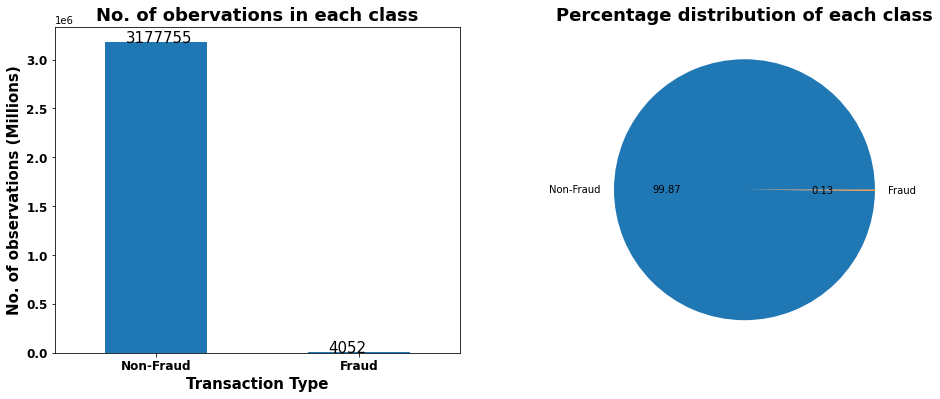

In [31]:
plt.subplots(1,2, figsize=(16,6))

# countplot to visualize the no. of observations under each class
plt.subplot(1,2,1)
ax = pd_df['isFraud'].value_counts().plot(kind='bar')
plt.xlabel('Transaction Type', fontsize=15, fontweight='bold')
plt.xticks(ticks=[0,1], labels=['Non-Fraud','Fraud'], rotation=0, fontsize=12, fontweight='bold')
plt.ylabel('No. of observations (Millions)', fontsize=15, fontweight='bold')
plt.yticks(fontsize=12, fontweight='bold')
plt.title('No. of obervations in each class', fontsize=18, fontweight='bold')
for i in ax.patches:
    ax.text(i.get_x()+0.1, i.get_height()+3, str(round(i.get_height(), 2)), fontsize=15, color='black')

# pie chart to visualize the percentage distribution of each class
plt.subplot(1,2,2)
plt.pie(pd_df['isFraud'].value_counts(), labels=['Non-Fraud','Fraud'], autopct='%.2f')
plt.title('Percentage distribution of each class', fontsize=18, fontweight='bold')

# display plot
plt.show()

### Observations:

Les observations de transactions frauduleuses ne sont que 8 213 transactions (0,13 %). La fraude est rare.

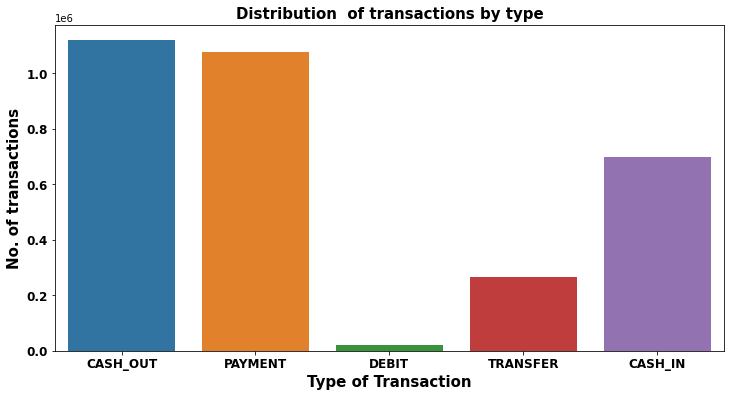

In [32]:
plt.subplots(figsize=(12,6))
sns.countplot('type', data=pd_df)
plt.xlabel('Type of Transaction', fontsize=15, fontweight='bold')
plt.xticks(fontsize=12, fontweight='bold')
plt.ylabel('No. of transactions', fontsize=15, fontweight='bold')
plt.yticks(fontsize=12, fontweight='bold')
plt.title('Distribution  of transactions by type', fontsize=15, fontweight='bold')
plt.show()

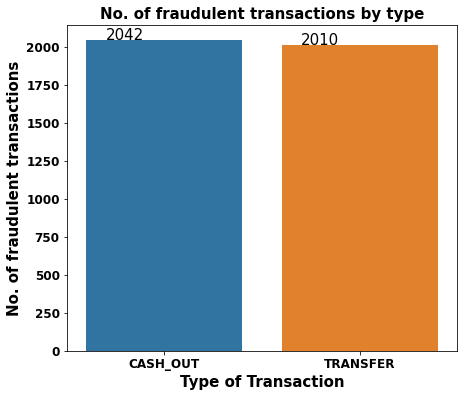

In [34]:
plt.subplots(figsize=(7,6))
fr_df = pd_df[pd_df['isFraud'] == 1]
ax =sns.countplot('type', data=fr_df)
for i in ax.patches:
    ax.text(i.get_x()+0.1, i.get_height()+3, str(round(i.get_height(), 2)), fontsize=15, color='black')
plt.xlabel('Type of Transaction', fontsize=15, fontweight='bold')
plt.xticks(fontsize=12, fontweight='bold')
plt.ylabel('No. of fraudulent transactions', fontsize=15, fontweight='bold')
plt.yticks(fontsize=12, fontweight='bold')
plt.title('No. of fraudulent transactions by type', fontsize=15, fontweight='bold')
plt.show()

In [35]:
print(fr_df['type'].value_counts()/len(fr_df))

CASH_OUT    0.503949
TRANSFER    0.496051
Name: type, dtype: float64


Nous pouvons observer que les transactions frauduleuses sont uniquement des retraits (cash_out) et des virements (transfer) avec des taux de fraude de 0.5% pour chacun d'entre eux.

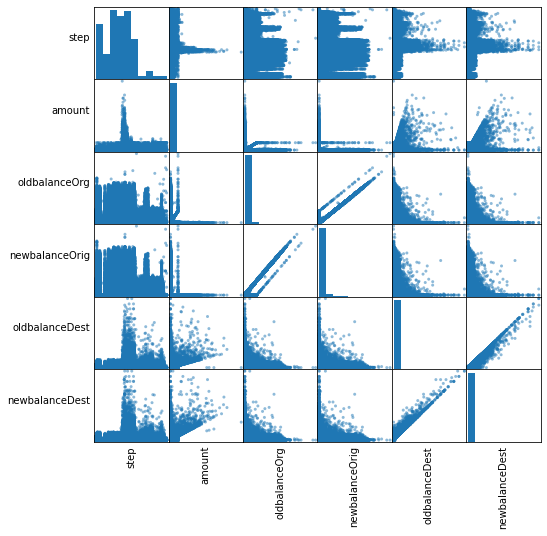

In [ ]:
import pandas as pd
from pandas.plotting import scatter_matrix

numeric_features = ['step', 'amount', 'oldbalanceOrg',
                    'newbalanceOrig','oldbalanceDest', 
                    'newbalanceDest']

numeric_data = df.select(numeric_features).toPandas()
axs = pd.plotting.scatter_matrix(numeric_data, figsize=(8, 8));
n = len(numeric_data.columns)
for i in range(n):
    v = axs[i, 0]
    v.yaxis.label.set_rotation(0)
    v.yaxis.label.set_ha('right')
    v.set_yticks(())
    h = axs[n-1, i]
    h.xaxis.label.set_rotation(90)
    h.set_xticks(())

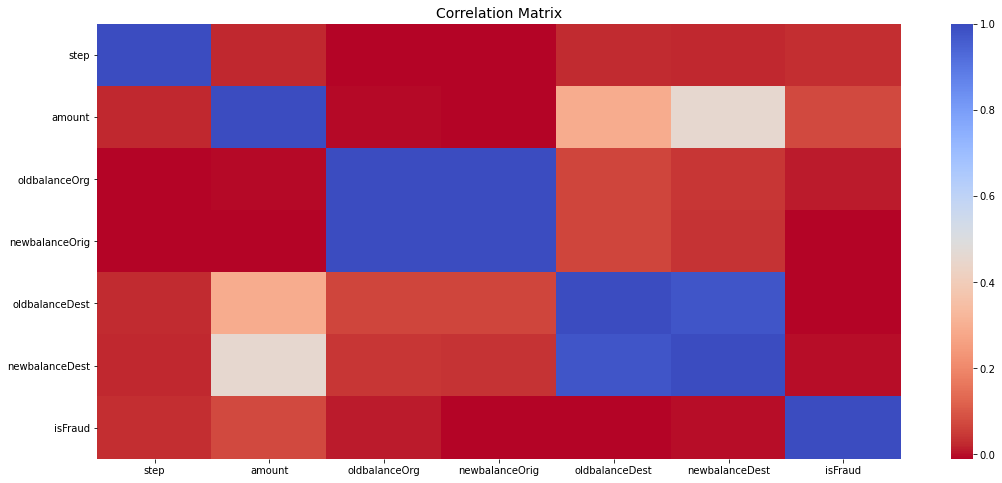

In [ ]:
# we can check the important parameters that could effect our model.
f, ax = plt.subplots(figsize=(18,8))

sub_sample_corr = pd_df.corr()
sns.heatmap(sub_sample_corr, cmap='coolwarm_r', annot_kws={'size':20}, ax=ax)
ax.set_title('Correlation Matrix', fontsize=14)
plt.show()

Ici, on peut observer qu'il y a des variables corrélées entre elles, d'où une redondance dans les données.
- La variable "oldbalanceDest" et "newbalanceDest" sont corrélées, on doit donc supprimer une d'entre elles. Pour décider laquelle supprimer, on doit vérifier leurs corrélations avec la variable dépendante "isFraud", "oldbalanceDest" est fortement corrélé négativement avec elle que "newbalanceDest". Donc, je dois supprimer la variable "newbalanceDest".

- De même " oldbalanceOrig" et "newbalanceOrig" sont également corrélés entre elles et newbalanceOrig est fortement corrélé négativement avec "isFraud" que "oldbalanceOrg". Donc, je dois supprimer la variable "oldbalanceOrig".